In [47]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RepeatedStratifiedKFold

from pycaret.classification import setup, compare_models, tune_model, finalize_model, predict_model
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from pycaret.classification import get_config

from pycaret.classification import plot_model
from pycaret.classification import interpret_model

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from pycaret.classification import save_model, load_model

import json


In [ ]:
# Load data
df = pd.read_csv("../data/past_information.csv")


# Drop irrelevant columns
df = df.drop(columns=["Unnamed: 0", "id"])

# Separate features and target
X = df.drop(columns=["stroke"])
y = df["stroke"]

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

# One-hot encode categorical variables
encoder = OneHotEncoder(drop="first", sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[cat_cols]), columns=encoder.get_feature_names_out(cat_cols))
X_encoded


# Combine with numerical features
X_full = pd.concat([X[num_cols].reset_index(drop=True), X_encoded.reset_index(drop=True)], axis=1)


# Apply KNN imputation for missing values
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X_full), columns=X_full.columns)

# Final dataset ready for PyCaret
final_data = pd.concat([X_imputed, y.reset_index(drop=True)], axis=1)

In [3]:
final_data['stroke'].value_counts()

stroke
0    4860
1     249
Name: count, dtype: int64

In [4]:
# Create your CV splitter
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=123)

# Setup with custom CV, hold-out test is still created automatically
s = setup(
    data=final_data,
    target="stroke",
    session_id=123,
    fold_strategy=cv,
    train_size=0.8,  # 80% train-val (with repeated CV), 20% holdout test
    preprocess=False)

# Compare models on repeated CV
best_model = compare_models(sort="AUC")

# Tune using the same repeated CV
tuned_model = tune_model(best_model, optimize="AUC")

# Lock model and retrain on all train+val
final_model = finalize_model(tuned_model)

,Description,Value
0,Session id,123
1,Target,stroke
2,Target type,Binary
3,Original data shape,"(5109, 17)"
4,Transformed data shape,"(5109, 17)"
5,Transformed train set shape,"(4087, 17)"
6,Transformed test set shape,"(1022, 17)"
7,Numeric features,16


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9515,0.8299,0.0045,0.1800,0.0088,0.0083,0.0275,0.1012
ridge,Ridge Classifier,0.9513,0.8240,0.0000,0.0000,0.0000,0.0000,0.0000,0.0032
lda,Linear Discriminant Analysis,0.9460,0.8240,0.0522,0.2566,0.0856,0.0698,0.0948,0.0032
gbc,Gradient Boosting Classifier,0.9485,0.8098,0.0096,0.1256,0.0172,0.0105,0.0205,0.0404
ada,Ada Boost Classifier,0.9502,0.8001,0.0076,0.1683,0.0143,0.0108,0.0270,0.0190
nb,Naive Bayes,0.4063,0.7995,0.9679,0.0746,0.1384,0.0528,0.1564,0.0036
lightgbm,Light Gradient Boosting Machine,0.9459,0.7948,0.0387,0.2083,0.0635,0.0493,0.0682,0.0840
rf,Random Forest Classifier,0.9503,0.7734,0.0045,0.0833,0.0085,0.0057,0.0124,0.0410
et,Extra Trees Classifier,0.9452,0.7340,0.0347,0.1828,0.0574,0.0426,0.0592,0.0338
svm,SVM - Linear Kernel,0.9145,0.6845,0.1025,0.0423,0.0428,0.0293,0.0383,0.0050


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9511,0.8324,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9511,0.8263,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9523,0.8298,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9510,0.8562,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9510,0.8087,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9511,0.8011,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9511,0.8438,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9523,0.8267,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9510,0.8856,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 50 folds for each of 10 candidates, totalling 500 fits


In [5]:
test_results = predict_model(final_model, raw_score=True)  # Holdout predictions

y_true = test_results['stroke']
y_prob = test_results['prediction_score_1']

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    f1_scores.append(f1_score(y_true, y_pred))

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best threshold: {best_threshold:.2f}, F1: {best_f1:.3f}")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9511,0.8767,0.0000,0.0000,0.0000,0.0000,0.0000


Best threshold: 0.14, F1: 0.347


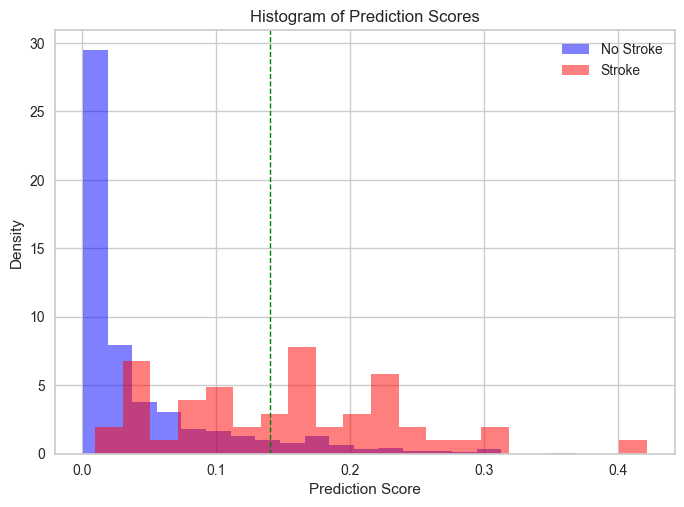

In [ ]:



import matplotlib.pyplot as plt
plt.hist(y_prob[y_true == 0], bins=20, alpha=0.5, label='No Stroke', color='blue', density=True)
plt.hist(y_prob[y_true == 1], bins=20, alpha=0.5, label='Stroke', color='red', density=True)
plt.axvline(best_threshold, color='green', linestyle='dashed', linewidth=1)
plt.title('Histogram of Prediction Scores')
plt.xlabel('Prediction Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [40]:
# plot the histogram of the prediction score for both classes in plotly

# Define common bin edges
bins = np.linspace(0, 1, 31) # 20 bins between 0 and 1

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=y_prob[y_true == 0],
    xbins=dict(start=bins[0], end=bins[-1], size=bins[1]-bins[0]),
    name='No Stroke',
    opacity=0.5,
    marker_color='blue',
    histnorm='probability density'
))
fig.add_trace(go.Histogram(
    x=y_prob[y_true == 1],
    xbins=dict(start=bins[0], end=bins[-1], size=bins[1]-bins[0]),
    name='Stroke',
    opacity=0.5,
    marker_color='red',
    histnorm='probability density'
))
fig.add_vline(x=best_threshold, line_width=2, line_dash="dash", line_color="green", annotation_text="Best Threshold", annotation_position="top right")
fig.update_layout(
    title='Histogram of Prediction Scores in the Test Set',
    xaxis_title='Prediction Score',
    yaxis_title='Density',
    barmode='overlay'  # <--- This overlays the bars
)
fig.show()

# Save to JSON
with open("../content/score_dist.json", "w") as f:
    f.write(fig.to_json())

In [7]:
# Get predictions (including probabilities) on the train set
train_predictions = predict_model(tuned_model, data=get_config("X_train"), raw_score=True)
y_prob_train = train_predictions['prediction_score_1']
y_train = get_config("y_train")

In [32]:
# divide the predictions into four quartiles
quartiles = pd.qcut(y_prob_train, 4, labels=False)
# calculate the actual stroke rate in each quartile
stroke_rates = [y_train[quartiles == i].mean() for i in range(4)]
# calculate the limits of each quartile
quartile_limits = pd.qcut(y_prob_train, 4).unique().categories
# print stroke rates per quartile
print("Stroke rates per quartile (0=lowest risk, 3=highest risk):")
print(stroke_rates)
print("Quartile limits:")
print(quartile_limits)


Stroke rates per quartile (0=lowest risk, 3=highest risk):
[0.001953125, 0.008771929824561403, 0.03842364532019704, 0.14579256360078277]
Quartile limits:
IntervalIndex([(-0.00030000000000000003, 0.0053], (0.0053, 0.0205], (0.0205, 0.0633], (0.0633, 0.485]], dtype='interval[float64, right]')


In [33]:
# now getting the probabilities for the holdout set
test_results = predict_model(final_model, raw_score=True)  # Holdout predictions
y_true = test_results['stroke']
y_prob = test_results['prediction_score_1']

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9511,0.8767,0.0000,0.0000,0.0000,0.0000,0.0000


In [34]:
# divide the test predictions into the range defined by the train quartiles
quartiles_test = pd.cut(y_prob, bins=[-0.01] + list(quartile_limits.right), labels=False)
# calculate the actual stroke rate in each quartile
stroke_rates_test = [y_true[quartiles_test == i].mean() for i in range(4)]
# print stroke rates per quartile
print("Test Stroke rates per quartile (0=lowest risk, 3=highest risk):")
print(stroke_rates_test)


Test Stroke rates per quartile (0=lowest risk, 3=highest risk):
[0.0, 0.003937007874015748, 0.03862660944206009, 0.15873015873015872]


In [41]:
# using plotly, create a bar plot of the stroke rates per quartile for both train and test sets
import plotly.graph_objects as go
fig = go.Figure(data=[
    go.Bar(name='Train Set', x=['Q1', 'Q2', 'Q3', 'Q4'], y=stroke_rates, marker_color='blue'),
    go.Bar(name='Test Set', x=['Q1', 'Q2', 'Q3', 'Q4'], y=stroke_rates_test, marker_color='red')
])
fig.update_layout(
    title='Stroke Rates per Quartile in Train and Test Sets',
    xaxis_title='Quartiles (0=Lowest Risk, 3=Highest Risk)',
    yaxis_title='Stroke Rate',
    barmode='group'
)
fig.show()

# Save to JSON
with open("../content/risk_levels.json", "w") as f:
    f.write(fig.to_json())

In [ ]:
# save the quartile limits and stroke rates to json
quartile_data = {
    "quartile_limits": [str(interval) for interval in quartile_limits],
    "test_stroke_rates": stroke_rates_test
}
with open("../content/quartile_data.json", "w") as f:
    json.dump(quartile_data, f)

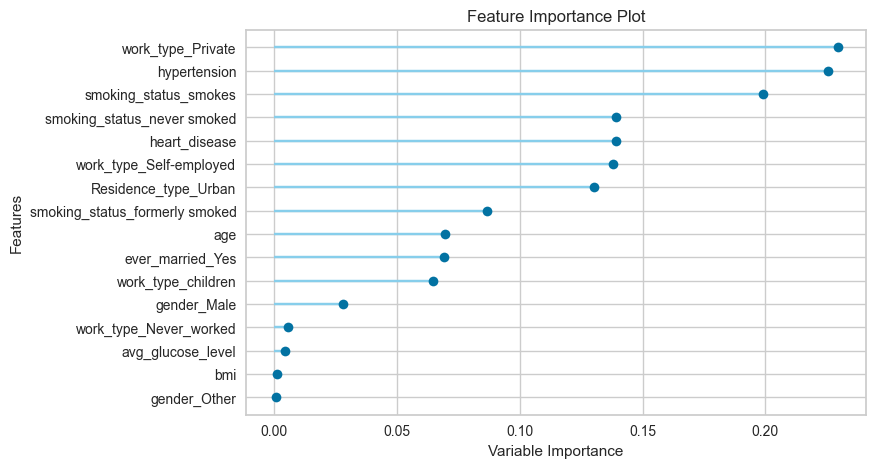

In [11]:
# Summary plot (global interpretability)
plot_model(tuned_model, plot='feature_all')

In [13]:
tuned_model

LogisticRegression(C=0.056, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:

# Access coefficients and intercept
coeffs = tuned_model.coef_
intercept = tuned_model.intercept_

print("Intercept:", intercept)
print("Coefficients:", coeffs)

Intercept: [-7.60225925]
Coefficients: [[ 0.06938658  0.22535307  0.13904857  0.00423431  0.0012333  -0.02789263
  -0.00083743 -0.06926564 -0.00549836  0.2295652  -0.1379987   0.06467946
   0.13030242  0.0865347  -0.13921129  0.19897382]]


In [20]:
#Get feature names from PyCaret’s preprocessing pipeline
feature_names = get_config("X_train").columns

# Create a DataFrame with coefficients
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coeffs.flatten()
}).sort_values(by="Coefficient", ascending=False)

coef_df  # Top 10 most positive predictors

,Feature,Coefficient
9,work_type_Private,0.229565
1,hypertension,0.225353
15,smoking_status_smokes,0.198974
2,heart_disease,0.139049
12,Residence_type_Urban,0.130302
13,smoking_status_formerly smoked,0.086535
0,age,0.069387
11,work_type_children,0.064679
3,avg_glucose_level,0.004234
4,bmi,0.001233


In [43]:
# plot the coefficients using plotly
fig = px.bar(coef_df.head(20), x='Feature', y='Coefficient', title='Top 20 Feature Coefficients')
fig.update_layout(xaxis_tickangle=90)
fig.show()

# Save to JSON
with open("../content/coefficients.json", "w") as f:
    f.write(fig.to_json())

In [45]:
# Save the final model
save_model(final_model, "../content/stroke_risk_model")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('clean_column_names',
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                 ('actual_estimator',
                  LogisticRegression(C=0.056, class_weight={}, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=1000,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=123,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False),
 '../content/stroke_risk_model.pkl')

In [56]:
final_data.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_Male', 'gender_Other', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'stroke'],
      dtype='object')

In [58]:
# for each column in final_data, store the mean and std in a dictionary for future normalization
scaling_params = {}
for col in final_data.columns:
    scaling_params[col] = {
        "mean": final_data[col].mean(),
        "std": final_data[col].std()
    }
with open("../content/scaling_params.json", "w") as f:
    json.dump(scaling_params, f)